# Setup

In [1]:
#Colab
# from google.colab import drive
# drive.mount('/content/drive')
# GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#HPC
GNN_PATH = './GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

In [2]:
# Install packages
!pip install torch-geometric torch scikit-learn pandas shapely seaborn
!pip install git+https://github.com/Thinklab-SJTU/pygmtools.git #pygmtools library

# Check pytorch version and make sure you use a GPU Kernel
!python3 -c "import torch; print(torch.__version__)"
!python3 -c "import torch; print(torch.version.cuda)"
!python3 --version
!nvidia-smi

  Cloning https://github.com/Thinklab-SJTU/pygmtools.git to /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-w105bllv
  Running command git clone --filter=blob:none --quiet https://github.com/Thinklab-SJTU/pygmtools.git /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-w105bllv
  Resolved https://github.com/Thinklab-SJTU/pygmtools.git to commit 80399b1b07722340dd8d6e1bcce2618395fac2db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.2.2
None
Python 3.8.9
zsh:1: command not found: nvidia-smi


In [3]:
import pickle
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import torch
import networkx as nx
from torch_geometric.data import Data
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import translate
import networkx as nx
import copy

In [4]:
# Set Seed for reproducibility
seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

# Utilities

In [5]:
#----------------------------------------
#            DATASET UTILS
#----------------------------------------
def deserialize_MSD_dataset(data_path):
    dataset_dir = Path(data_path)

    # Load dimensions
    dimensions_file = dataset_dir / "dimensions.pickle"
    if not dimensions_file.exists():
        raise FileNotFoundError(f"Dimensions file not found at {dimensions_file}")
    with open(dimensions_file, 'rb') as f:
        dimensions = pickle.load(f)

    # Clear existing graphs
    original = []
    noise = []

    def extract_numeric_key(file):
        """Extracts (X, Y) from filenames like 'X_Y.pt' for proper numeric sorting."""
        name_parts = file.stem.split("_")
        return int(name_parts[0]), int(name_parts[1])

    original_dir = dataset_dir / "original"
    original_files = sorted(original_dir.glob("*.pt"), key=lambda f: int(f.stem))

    for file in original_files:
        graph = nx.DiGraph()
        with open(str(file), "rb") as f:
            graph = pickle.load(f)
            graph.graph['name'] = file.stem
        original.append(graph)


    noise_dir = dataset_dir / "noise"
    noise_files = sorted(noise_dir.glob("*.pt"), key=extract_numeric_key)

    for file in noise_files:
        graph = nx.DiGraph()
        with open(str(file), "rb") as f:
            graph = pickle.load(f)
            graph.graph['name'] = file.stem
        noise.append(graph)

    return original, noise, dimensions

# TODO : definisci serialaze e deserialize per il nuovo dataset

def plot_a_graph(graphs_list, viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=False, viz_walls=True):
    """
    Visualizes geometries, wall segments, and graph edges for multiple apartments in 2D.

    Parameters:
    graphs_list (list of networkx.Graph): List of graphs with nodes ('type', 'center', 'normal') and edges for the apartments.
    viz_normals (bool): If True, plots wall segment normals.
    viz_rooms (bool): If True, displays room polygons.
    viz_ws (bool): If True, displays wall segments.
    viz_openings (bool): If True, displays openings (doors and windows).
    viz_wall_edges (bool): If True, displays edges between wall segments.
    viz_connection_edges (bool): If True, displays edges connecting rooms via openings.
    viz_walls (bool): If True, displays wall nodes and their edges.
    """
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    legend_added = False  # Flag to ensure the legend is added only once
    normal_added = False  # Flag to ensure the "Normal" label is added only once

    for graphs in graphs_list:
        # Visualize room polygons
        if viz_rooms:
            room_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'room']
            for idx, room_node in enumerate(room_nodes):
                room_data = graphs.nodes[room_node]
                # Plot the polygon
                room_polygon = Polygon(room_data['polygon'])
                x, y = room_polygon.exterior.xy
                ax.plot(x, y, color='black', label='Room polygon' if not legend_added and idx == 0 else "")
                # Draw room centroids
                ax.scatter(room_data['center'][0], room_data['center'][1], color='blue', s=100, label='Room centroid' if not legend_added and idx == 0 else "")

        # Visualize wall nodes and edges
        if viz_walls:
            wall_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall']
            for idx, wn in enumerate(wall_nodes):
                wall_data = graphs.nodes[wn]
                # Plot the polygon of the wall
                wall_polygon = Polygon(wall_data['polygon'])
                x, y = wall_polygon.exterior.xy
                ax.plot(x, y, color='purple', linestyle='-', label='Wall polygon' if not legend_added and idx == 0 else "")
                ax.scatter(wall_data['center'][0], wall_data['center'][1], color='purple', s=50, label='Wall centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                wall_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall_ws']
                for idx, wn in enumerate(wall_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='purple', s=20, label='Wall ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            wall_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'wall' in u or 'wall' in v]
            for idx, edge in enumerate(wall_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='purple', linestyle='--', label='Wall edge' if not legend_added and idx == 0 else "")

        # Visualize openings
        if viz_openings:
            opening_nodes = [n for n, d in graphs.nodes(data=True) if 'door' in d['type'] or 'window' in d['type']]
            for idx, on in enumerate(opening_nodes):
                opening_data = graphs.nodes[on]
                opening_polygon = Polygon(opening_data['polygon'])
                x, y = opening_polygon.exterior.xy
                ax.plot(x, y, color='orange', label='Opening polygon' if not legend_added and idx == 0 else "")
                # Draw opening centroids
                ax.scatter(opening_data['center'][0], opening_data['center'][1], color='orange', s=10, label='Opening centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                opening_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'door_ws' or d['type'] == 'window_ws']
                for idx, wn in enumerate(opening_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='orange', s=10, label='Opening ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            # Draw opening edges
            open_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'door' in u or 'window' in v or 'door' in v or 'window' in u]
            for idx, edge in enumerate(open_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='orange', linestyle='--', label='Opening edge' if not legend_added and idx == 0 else "")

        # Visualize ws room
        if viz_ws:
            ws_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'ws']
            for idx, wn in enumerate(ws_nodes):
                ws_data = graphs.nodes[wn]
                ax.scatter(ws_data['center'][0], ws_data['center'][1], color='red', s=20, label='Ws segment' if not legend_added and idx == 0 else "")
                if viz_room_normals:
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            ws_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'ws_same_room' in d['type'] or 'ws_belongs_room' in d['type']]
            for idx, edge in enumerate(ws_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                    [start_node['center'][1], end_node['center'][1]],
                    color='gray', linestyle='--', label='Ws edge' if not legend_added and idx == 0 else "")

        # Visualize connection edges
        if viz_room_connection:
            connection_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'connected' in d['type']]
            for idx, edge in enumerate(connection_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='blue', linestyle='-', label='Connection edge' if not legend_added and idx == 0 else "")

        legend_added = True  # Set the flag to True after processing the first graph

    plt.title("Apartment Graph Visualization")
    plt.legend()
    plt.show()

node_type_mapping = {"room": [1, 0], "ws": [0, 1]}
# Functions to convert DiGraphs to pyg data and viceversa, pyg data are more compatible with GNN models
def pyg_data_to_nx_digraph(data: Data, graph_list: List[nx.DiGraph]) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names and matching it
    with the graph in graph_list that has the same name.
    """
    assert hasattr(data, 'node_names'), "Data object must contain 'node_names' to restore original node IDs."
    assert hasattr(data, 'name'), "Data object must contain 'name' to match with graph_list."

    # Find the matching graph in the list by name
    matching_graph = next((g for g in graph_list if g.graph.get('name') == data.name), None)
    if matching_graph is None:
        raise ValueError(f"No graph with name {data.name} found in the provided graph_list.")

    G = nx.DiGraph()

    node_ids = data.node_names

    # Add nodes with attributes from the matching graph
    for i, node_id in enumerate(node_ids):
        if node_id in matching_graph.nodes:
            G.add_node(node_id, **matching_graph.nodes[node_id])

    # Add edges mapped back to original IDs
    edge_index = data.edge_index
    for u_idx, v_idx in edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        if matching_graph.has_edge(u, v):
            G.add_edge(u, v, **matching_graph.edges[u, v])

    # Add the graph name
    G.graph['name'] = data.name
    G.graph['node_names'] = data.node_names

    return G
    
def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving the insertion order of nodes.
    """
    node_ids = list(graph.nodes())  # preserve insertion order
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Build node features tensor
    x = torch.stack([
        torch.tensor(
            node_type_mapping[graph.nodes[n]['type']] +  # One-hot encoding for 'type'
            graph.nodes[n]['center'] +  # 'center' coordinates
            graph.nodes[n]['normal'] +  # 'normal' vector
            [graph.nodes[n].get('width', -1)],  # 'width', default to -1 if not present
            dtype=torch.float32
        )
        for n in node_ids
    ])

    # Remap edges using the insertion-order mapping
    edge_index = torch.tensor([
        [id_map[u], id_map[v]] for u, v in graph.edges()
    ], dtype=torch.long).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    # Optionally, store the original node order as a list of IDs
    data = Data(x=x, edge_index=edge_index)
    data.node_names = node_ids  # so you can always recover original labels
    data.name = graph.graph.get("name")

    return data

def generate_matching_pairs_as_data(
    g1: nx.DiGraph,
    graph_list: List[nx.DiGraph],
    g1_idx: int,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate matching pairs as torch_geometric Data objects with a permutation matrix.

    Args:
        g1: Reference graph as networkx.DiGraph
        graph_list: List of all networkx.DiGraphs
        g1_idx: Index of g1 in graph_list (to skip self-pairs)
        pairs_list: List to store (Data1, Data2_permuted, P) tuples
    """

    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    for j, g2_orig in enumerate(graph_list):
        if j != g1_idx:
            continue

        assert g2_orig.number_of_nodes() == pyg_g1.num_nodes, f"Mismatch nodes in g1 ({g1_idx}) and g2 ({j})"

        num_nodes = g2_orig.number_of_nodes()
        nodes_g2 = list(sorted(g2_orig.nodes()))
        assert nodes_g2 == list(range(num_nodes)), "Nodes must be consecutively indexed"

        # Create a random permutation
        perm = torch.randperm(num_nodes) # [2, 4, 1, 3, 0] for example
        # Identiy permutation
        # perm = torch.arange(num_nodes) # [0, 1, 2, 3, 4] for example

        # Build the permutation matrix: P[i, j] = 1 if node i in G1 node j in G2_permuted
        P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        for i in range(num_nodes):
            P[i, perm[i]] = 1.0

        # Create permuted G2
        g2_permuted = nx.DiGraph()
        g2_permuted.graph['name'] = g2_orig.graph['name']  # Copy the name of the graph

        for new_idx in range(num_nodes):
            old_idx = perm[new_idx].item()
            g2_permuted.add_node(
                new_idx,
                type=g2_orig.nodes[old_idx]['type'],
                center=g2_orig.nodes[old_idx]['center'],
                normal=g2_orig.nodes[old_idx]['normal'],
                width=g2_orig.nodes[old_idx].get('width', -1)
            )

        for u, v, data in g2_orig.edges(data=True):
            new_u = (perm == u).nonzero(as_tuple=True)[0].item()
            new_v = (perm == v).nonzero(as_tuple=True)[0].item()
            g2_permuted.add_edge(new_u, new_v, **data)

        pyg_g2 = nx_to_pyg_data_preserve_order(g2_permuted)
        pairs_list.append((pyg_g1, pyg_g2, P.T))  # P.T so that P[i, j] = G1[i] ↔ G2[j]

#----------------------------------------
#            TRAINING UTILS
#----------------------------------------

# Create the plot
def plot_losses(train_losses, val_losses):
    epochs = list(range(len(train_losses)))
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
    sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def apply_inverse_permutation_to_graph(g2: nx.DiGraph, inv_perm: torch.Tensor) -> nx.DiGraph:
    """
    Riordina i nodi del grafo g2 secondo la permutazione inversa.
    """
    reordered = nx.DiGraph()
    mapping = {}

    for i, original_idx in enumerate(inv_perm.tolist()):
        node_data = g2.nodes[original_idx]
        reordered.add_node(i, **node_data)
        mapping[original_idx] = i

    for u, v, data in g2.edges(data=True):
        if u in mapping and v in mapping:
            reordered.add_edge(mapping[u], mapping[v], **data)

    reordered.graph.update(g2.graph)  # copy graph-level attributes
    return reordered

def plot_two_graphs_with_matching(graphs_list, gt_perm, pred_perm, original_graphs,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False,
                                  match_display="all"): 
    """
    Visualizes two graphs side by side with matching edges.
    G1 is plotted as-is, G2 is translated to the right.

    Args:
        graphs_list (list): [G1, G2] as networkx.DiGraph
        gt_perm (Tensor): Ground truth permutation matrix
        pred_perm (Tensor): Predicted permutation matrix
        match_display (str): 'all', 'correct', or 'wrong'
    """
    assert match_display in {"all", "correct", "wrong"}, "match_display must be one of: 'all', 'correct', 'wrong'"
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    
    g1tensor, g2tensor = copy.deepcopy(graphs_list[0]), copy.deepcopy(graphs_list[1])  # avoid modifying original

    #Convert tensor to digraph for rappresentation
    g1 = copy.deepcopy(pyg_data_to_nx_digraph(g1tensor, original_graphs))
    g2_original = copy.deepcopy(pyg_data_to_nx_digraph(g2tensor, original_graphs))

    # Apply inverse permutation to g2 to get the correct matching
    inv_perm = gt_perm.T.argmax(dim=1)
    g2 = apply_inverse_permutation_to_graph(g2_original, inv_perm)

    # Check if the permuted graphs are equal
    # convert g2_reordered in pyg
    g2_reordered_pyg = nx_to_pyg_data_preserve_order(g2)
    assert torch.equal(g2tensor.x, g2_reordered_pyg.x), "I tensori non sono uguali!"
    
    # Compute translation
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 10.0

    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = data['polygon']
            if isinstance(poly, Polygon):
                data['polygon'] = translate(poly, xoff=translation_x)
            else:
                data['polygon'] = Polygon([(x + translation_x, y) for x, y in poly])

    fig, ax = plt.subplots(figsize=(16, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'blue' if is_g1 else 'orange'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"

        if viz_rooms:
            for n, d in g.nodes(data=True):
                if d['type'] == 'room':
                    if 'polygon' in d:
                        poly = d['polygon']
                        if not isinstance(poly, Polygon):
                            poly = Polygon(poly)
                        x, y = poly.exterior.xy
                        ax.plot(x, y,
                                color='black' if is_g1 else 'gray',
                                linewidth=1, alpha=0.6,
                                label=f"Room polygon {prefix}" if "room-poly-"+prefix not in legend_added else "")
                        legend_added.add("room-poly-"+prefix)

                    ax.scatter(d['center'][0], d['center'][1],
                               color=color_room, s=80,
                               label=f"Centroid {prefix}" if "room-pt-"+prefix not in legend_added else "")
                    legend_added.add("room-pt-"+prefix)

        if viz_ws:
            for n, d in g.nodes(data=True):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if "ws-"+prefix not in legend_added else "")
                    legend_added.add("ws-"+prefix)

    # Plot nodes and polygons
    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    # Draw matchings based on predicted permutation
    for i in range(pred_perm.shape[0]):
        j = pred_perm[i].argmax().item()

        pt1 = g1.nodes[i]['center']
        pt2 = g2.nodes[j]['center']
        
        is_correct = gt_perm[i, j] == 1

        if match_display == "correct" and not is_correct:
            continue
        if match_display == "wrong" and is_correct:
            continue

        color = 'green' if is_correct else 'red'
        label = None
        if color == 'green' and 'correct' not in legend_added:
            label = 'Correct match'
            legend_added.add('correct')
        elif color == 'red' and 'wrong' not in legend_added:
            label = 'Wrong match'
            legend_added.add('wrong')

        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                color=color, linestyle='-', alpha=0.6, linewidth=1, label=label)

        ax.set_title("Graph Matching: Green = Correct, Red = Wrong")
        ax.axis("equal")
        ax.legend()
    plt.tight_layout()
    plt.show()




# Willow object 

## Willow object Class dataset

In [ ]:
# Set backend (required for pygmtools to work)
import pygmtools as pygm
pygm.set_backend('pytorch')  # or 'jittor', 'numpy' if you prefer

# Load the WillowObject dataset
from pygmtools.dataset import WillowObject

size = 1024  # Image size

# Load dataset
dataset = WillowObject(
    sets='train',           # Either 'train' or 'test'
    obj_resize=(size, size)   # Resize objects to a consistent image size
)

dataset.process()

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths
categories = ["Car", "Motorbike"]
base_path = "data/WillowObject/WILLOW-ObjectClass"
dataset_path = os.path.join("data/WillowObject", f"data-({size}, {size})-willow-0.json")

# Number of images
n_images = 5

# Load and visualization
fig, axes = plt.subplots(len(categories), n_images, figsize=(15, 5))
for i, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = sorted([f for f in os.listdir(category_path) if f.endswith(".png")])[:n_images]
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(category_path, img_file)
        image = Image.open(img_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"{category} {j+1}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import Delaunay
import networkx as nx

# Load the JSON file
with open(dataset_path, "r") as f:
    data = json.load(f)

def plot_graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])

    # Plot image
    img = mpimg.imread(entry["path"])
    img_resized = Image.open(entry["path"]).resize((size, size))
    plt.imshow(img_resized)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='red', edge_color='yellow', node_size=50, with_labels=True)
    plt.axis('off')
    plt.title(entry["path"].split('/')[-1])
    plt.show()

# Separate the two lists
car_entries = {k: v for k, v in data.items() if v["cls"] == "Car"}
motorbike_entries = {k: v for k, v in data.items() if v["cls"] == "Motorbike"}

# Show graph for the first image only
for i, (key, entry) in enumerate(car_entries.items()):
    plot_graph_from_kpts(entry)
    break


In [ ]:
def graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    # Add name of the image
    G.graph['name'] = entry["path"].split('/')[-1].replace('.png', '')
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])
    return G

def get_graphs(entries):
    graphs = []
    for entry in entries:
        G = graph_from_kpts(entry)
        graphs.append(G)
    return graphs

In [ ]:
# Get graphs for car and motorbike entries
car_graphs = get_graphs(car_entries.values())
motorbike_graphs = get_graphs(motorbike_entries.values())

#make dir if not os.path.exists(base_path / graphs):
graphs_path = os.path.join(base_path, "Graphs")
car_path = os.path.join(graphs_path, "car")
motorbike_path = os.path.join(graphs_path, "motorbike")

if not os.path.exists(graphs_path):
    os.makedirs(car_path)
    os.makedirs(motorbike_path)

# Save graphs to disk
import pickle
with open(car_path + "car_graphs.pkl", "wb") as f:
    pickle.dump(car_graphs, f)
with open(motorbike_path + "motorbike_graphs.pkl", "wb") as f:
    pickle.dump(motorbike_graphs, f)
# Load graphs from disk
with open(car_path + "car_graphs.pkl", "rb") as f:
    car_graphs = pickle.load(f)
with open(motorbike_path + "motorbike_graphs.pkl", "rb") as f:
    motorbike_graphs = pickle.load(f)

# Check the number of graphs
print(f"Number of car graphs: {len(car_graphs)}")
print(f"Number of motorbike graphs: {len(motorbike_graphs)}")
# Check the first graph
print(car_graphs[0])
print(car_graphs[0].nodes(data=True))
print(car_graphs[0].edges(data=True))


## Graph Matching with pygmtools

### Spectral Matching

In [ ]:
import torch
import pygmtools as pygm
import functools
import numpy as np
from scipy.optimize import linear_sum_assignment

pygm.set_backend('pytorch')

# Nodes with positions
nodes1 = car_graphs[0].nodes(data=True)  # example of a car graph
edges1 = car_graphs[0].edges(data=True)  # example of a car graph

nodes2 = car_graphs[1].nodes(data=True)  # example of a car graph
edges2 = car_graphs[1].edges(data=True)  # example of a car graph

# === STEP 1: Base graph construction (e.g., "cars") ===
n = 10  # number of nodes

# Use the nodes and edges provided for graph 1
nodes1 = [(i, {'pos': data['pos']}) for i, data in nodes1]
edges1 = [(i, j, {}) for i, j, _ in edges1]

# === STEP 2: Apply permutation to graph 2 ===
perm = np.random.permutation(n)  # random permutation of nodes
# Node i of G2 corresponds to node perm[i] of G1
nodes2 = [(i, {'pos': data['pos']}) for i, data in nodes2]
nodes2 = [(perm[i], data) for i, data in nodes2]
nodes2 = sorted(nodes2, key=lambda x: x[0])  # sort by node ID

# Edges also need to be remapped
edges2 = [(perm[i], perm[j], {}) for (i, j, data) in edges2]

# === STEP 3: Ground truth: permutation matrix ===
X_gt = torch.zeros(n, n)
for i in range(n):
    X_gt[i, perm[i]] = 1  # node i of G1 → node perm[i] of G2

# === STEP 4: Convert data for pygmtools ===
def edges_to_adj(edges, n):
    adj = torch.zeros((n, n))
    for i, j, _ in edges:
        adj[i, j] = 1
        adj[j, i] = 1
    return adj

A1 = edges_to_adj(edges1, n).unsqueeze(0)
A2 = edges_to_adj(edges2, n).unsqueeze(0)

# Convert to sparse and build affinity matrix
conn1, edge1, ne1 = pygm.utils.dense_to_sparse(A1)
conn2, edge2, ne2 = pygm.utils.dense_to_sparse(A2)

n_tensor = torch.tensor([n])

gaussian_aff = functools.partial(pygm.utils.gaussian_aff_fn, sigma=1.)

K = pygm.utils.build_aff_mat(
    None, edge1, conn1,
    None, edge2, conn2,
    n_tensor, None, n_tensor, None,
    edge_aff_fn=gaussian_aff
)

# === STEP 5: Solve matching with SM ===
S = pygm.sm(K, n1=n_tensor, n2=n_tensor)
S = S.view(n, n).detach().numpy()

# Final matching
row_ind, col_ind = linear_sum_assignment(-S)
X_pred = np.zeros_like(S)
X_pred[row_ind, col_ind] = 1

# === STEP 6: Accuracy ===
acc = (torch.tensor(X_pred) * X_gt).sum() / X_gt.sum()
print(f"Matching accuracy: {acc.item():.2f}")
print("Predicted matching:", list(zip(row_ind, col_ind)))
print("Ground truth permutation:", perm)

# === STEP 7: Visualization ===
# Visualize in a single image the two cars and the two graphs with connections between matched nodes
def plot_graphs(nodes1, edges1, nodes2, edges2, entry1, entry2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graph 1 with image
    img1 = mpimg.imread(entry1["path"])
    img1_resized = Image.open(entry1["path"]).resize((size, size))
    axs[0].imshow(img1_resized)
    G1 = nx.Graph()
    G1.add_nodes_from(nodes1)
    G1.add_edges_from(edges1)
    pos1 = {i: data['pos'] for i, data in nodes1}
    nx.draw(G1, pos=pos1, ax=axs[0], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[0].set_title("Graph 1")
    axs[0].axis('off')

    # Graph 2 with image
    img2 = mpimg.imread(entry2["path"])
    img2_resized = Image.open(entry2["path"]).resize((size, size))
    axs[1].imshow(img2_resized)
    G2 = nx.Graph()
    G2.add_nodes_from(nodes2)
    G2.add_edges_from(edges2)
    pos2 = {i: data['pos'] for i, data in nodes2}
    nx.draw(G2, pos=pos2, ax=axs[1], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[1].set_title("Graph 2")
    axs[1].axis('off')

    plt.show()

# Example usage
plot_graphs(nodes1, edges1, nodes2, edges2, car_entries["Cars_000a"], car_entries["Cars_001b"])


### IPCA Model

In [ ]:
import torch
import numpy as np
import pygmtools as pygm
import torch.nn.functional as F
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import pygmtools as pygm
import torch

pygm.BACKEND = 'pytorch'

# Load graph data
graph1 = car_graphs[0]
graph2 = car_graphs[1]

nodes1 = graph1.nodes(data=True)
nodes2 = graph2.nodes(data=True)
edges1 = graph1.edges(data=True)
edges2 = graph2.edges(data=True)

plot_graphs(nodes1, edges1, nodes2, edges2, car_entries[graph1.graph['name']], car_entries[graph2.graph['name']])

adj1 = nx.adjacency_matrix(graph1).todense()
adj2 = nx.adjacency_matrix(graph2).todense()

# Extract node features (e.g., positions) from the graph nodes
g1_node_feat = torch.tensor([data['pos'] for _, data in graph1.nodes(data=True)], dtype=torch.float32)
g2_node_feat = torch.tensor([data['pos'] for _, data in graph2.nodes(data=True)], dtype=torch.float32)
adj1 = torch.tensor(adj1, dtype=torch.float32)
adj2 = torch.tensor(adj2, dtype=torch.float32)

print(f"Graph 1 node features shape: {g1_node_feat.shape}")
print(f"Graph 2 node features shape: {g2_node_feat.shape}")

desired_dim = 1024

# Padding with 0s
g1_node_feat_padded = F.pad(g1_node_feat, (0, desired_dim - g1_node_feat.shape[1]))
g2_node_feat_padded = F.pad(g2_node_feat, (0, desired_dim - g2_node_feat.shape[1]))

print(f"Graph 1 node features shape: {g1_node_feat_padded.shape}")
print(f"Graph 2 node features shape: {g2_node_feat_padded.shape}")

# Apply IPCA-GM model for graph matching
match_result = pygm.ipca_gm(
    A1=adj1.to(torch.float32), A2=adj2.to(torch.float32),
    feat1=g1_node_feat_padded, feat2=g2_node_feat_padded,
    pretrain='willow'
)

# Convert to a DataFrame for better readability
df_match = pd.DataFrame(match_result.detach().numpy())

matched = pygm.hungarian(match_result)
df_matched = pd.DataFrame(matched)

# Display the DataFrame in the terminal
# Calculate accuracy
identity_matrix = torch.eye(n)  # Ground truth is the identity matrix
accuracy = (matched * identity_matrix).sum() / identity_matrix.sum()

print("Graph Matching Matrix:")
print(df_match.to_string(index=True, header=True))
print("Hungarian:")
print(df_matched.to_string(index=True, header=True))
print(f"Matching Accuracy: {accuracy.item():.2f}")


The model expects an input of dimensions [10, 1024], which corresponds to features extracted from CNN layers applied to the image. Since we do not have access to these features, the results obtained are suboptimal.

## Graph Matching with GNN from scratch 

In [ ]:
# Set Seed for reproducibility
import random
import numpy as np
import torch

seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

### Dataset split

Functions to convert DiGraphs to pyg data and viceversa, pyg data are more compatible with GNN models

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
from typing import List, Tuple

def pyg_data_to_nx_digraph(data: Data) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names.
    """
    assert hasattr(data, 'node_names'), "Data object must contain 'node_names' to restore original node IDs."

    G = nx.DiGraph()
    node_ids = data.node_names

    # Aggiungi nodi con pos
    for i, node_id in enumerate(node_ids):
        G.add_node(node_id, pos=data.x[i].tolist())

    # Aggiungi archi mappati indietro a ID originali
    edge_index = data.edge_index
    for u_idx, v_idx in edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        G.add_edge(u, v)

    # Aggiungi nome del grafo, se esiste
    if hasattr(data, 'name') and data.name is not None:
        G.graph['name'] = data.name

    return G

def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving the insertion order of nodes.
    """
    node_ids = list(graph.nodes())  # preserve insertion order
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Build node features tensor
    x = torch.stack([
        torch.tensor(graph.nodes[n]['pos'], dtype=torch.float32)
        for n in node_ids
    ])

    # Remap edges using the insertion-order mapping
    edge_index = torch.tensor([
        [id_map[u], id_map[v]] for u, v in graph.edges()
    ], dtype=torch.long).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    # Optionally, store the original node order as a list of IDs
    data = Data(x=x, edge_index=edge_index)
    data.node_names = node_ids  # so you can always recover original labels
    data.name = graph.graph.get("name")

    return data

Generate G1,G2,GT dataset

In [ ]:
def generate_matching_pairs_as_data(
    g1: nx.DiGraph,
    graph_list: List[nx.DiGraph],
    g1_idx: int,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate matching pairs as torch_geometric Data objects with a permutation matrix.

    Args:
        g1: Reference graph as networkx.DiGraph
        graph_list: List of all networkx.DiGraphs
        g1_idx: Index of g1 in graph_list (to skip self-pairs)
        pairs_list: List to store (Data1, Data2_permuted, P) tuples
    """

    assert g1.number_of_nodes() == 10, f"Graph {g1_idx} has {g1.number_of_nodes()} nodes!"

    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    for j, g2_orig in enumerate(graph_list):
        if j == g1_idx:
            continue

        assert g2_orig.number_of_nodes() == pyg_g1.num_nodes, f"Mismatch nodes in g1 ({g1_idx}) and g2 ({j})"

        num_nodes = g2_orig.number_of_nodes()
        nodes_g2 = list(sorted(g2_orig.nodes()))
        assert nodes_g2 == list(range(num_nodes)), "Nodes must be consecutively indexed"

        # Create a random permutation
        perm = torch.randperm(num_nodes)

        # Build the permutation matrix: P[i, j] = 1 if node i in G1 ↔ node j in G2_permuted
        P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        for i in range(num_nodes):
            P[i, perm[i]] = 1.0

        # Create permuted G2
        g2_permuted = nx.DiGraph()
        g2_permuted.graph['name'] = g2_orig.graph['name']  # Copy the name of the graph

        for new_idx in range(num_nodes):
            old_idx = perm[new_idx].item()
            g2_permuted.add_node(new_idx, pos=g2_orig.nodes[old_idx]['pos'])

        for u, v, data in g2_orig.edges(data=True):
            new_u = (perm == u).nonzero(as_tuple=True)[0].item()
            new_v = (perm == v).nonzero(as_tuple=True)[0].item()
            g2_permuted.add_edge(new_u, new_v, **data)

        pyg_g2 = nx_to_pyg_data_preserve_order(g2_permuted)
        pairs_list.append((pyg_g1, pyg_g2, P.T))  # P.T so that P[i, j] = G1[i] ↔ G2[j]

# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

cars_train, cars_val, cars_test = split_graphs(car_graphs)

train_list = []
for i, g1 in enumerate(cars_train):
    generate_matching_pairs_as_data(g1, cars_train, i, train_list)

val_list = []
for i, g1 in enumerate(cars_val):
    generate_matching_pairs_as_data(g1, cars_val, i, val_list)

test_list = []
for i, g1 in enumerate(cars_test):
    generate_matching_pairs_as_data(g1, cars_test, i, test_list)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = test_list[0]

g1_out = pyg_data_to_nx_digraph(g1_out)
g2_perm = pyg_data_to_nx_digraph(g2_perm)

plot_graphs(
    nodes1=g1_out.nodes(data=True),
    edges1=g1_out.edges(data=True),
    nodes2=g2_perm.nodes(data=True),
    edges2=g2_perm.edges(data=True),
    entry1=data[g1_out.name],
    entry2=data[g2_perm.name]
)

print("G1 nodes:", g1_out.nodes(data=True))
print("G2 permuted nodes:", g2_perm.nodes(data=True))
print("Ground truth permutation:\n", gt_perm)

In [ ]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    perm_tensor = torch.stack(perm_list)  # shape [B, N, N]
    return batch1, batch2, perm_tensor

In [ ]:
# Define hyperparameters
in_dim = 2  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 20
learning_rate = 0.001
batch_size = 5

from torch.utils.data import DataLoader

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

### Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MatchingModel_2GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),
            GCNConv(hidden_dim, out_dim)
        ])

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x  # shape [num_nodes, out_dim]

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Args:
            x1, x2: node features of graph 1 and 2 (shapes [N, in_dim])
            edge_index1, edge_index2: edge indices of graph 1 and 2 ([2, num_edges])

        Returns:
            scores: similarity matrix [N, N], where scores[i, j] = node i in G1 vs node j in G2
        """
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]
        scores = torch.matmul(h1, h2.T)    # [N, N]
        return scores

### Training

In [ ]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch.

    Args:
        model: The graph matching model to train.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.
        optimizer: Optimizer for updating model parameters.

    Returns:
        The average loss over all batches.
    """
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss

    for batch1, batch2, P in loader:  # Iterate over batches
        optimizer.zero_grad()  # Reset gradients

        # Extract node features and edge indices for both graphs
        x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
        x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

        # Encode node features using the model
        h1 = model.encode(x1, edge1)
        h2 = model.encode(x2, edge2)

        loss = 0.0  # Initialize batch loss
        B = P.size(0)  # Number of graphs in the batch
        N = P.size(1)  # Number of nodes in each graph

        for i in range(B):  # Iterate over graphs in the batch
            # Select node embeddings for the current graph pair
            h1_i = h1[batch_idx1 == i]  # Node embeddings for graph 1
            h2_i = h2[batch_idx2 == i]  # Node embeddings for graph 2

            # Compute similarity matrix between nodes of the two graphs
            sim = torch.matmul(h1_i, h2_i.T)  # Shape: [N, N]

            # Compute binary cross-entropy loss between similarity and ground truth permutation
            loss += F.binary_cross_entropy_with_logits(sim, P[i])

        loss /= B  # Average loss over the batch
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate total loss

    return total_loss / len(loader)  # Return average loss over all batches

def evaluate(model, loader):
    """
    Evaluate the model on a validation or test set.

    Args:
        model: The graph matching model to evaluate.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.

    Returns:
        The accuracy of the model.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total predictions counter

    with torch.no_grad():  # Disable gradient computation
        for batch1, batch2, P in loader:  # Iterate over batches
            # Extract node features and edge indices for both graphs
            x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
            x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

            # Encode node features using the model
            h1 = model.encode(x1, edge1)
            h2 = model.encode(x2, edge2)

            B, N = P.size(0), P.size(1)  # Number of graphs and nodes

            for i in range(B):  # Iterate over graphs in the batch
                # Select node embeddings for the current graph pair
                h1_i = h1[batch_idx1 == i]
                h2_i = h2[batch_idx2 == i]

                # Compute similarity matrix between nodes of the two graphs
                sim = torch.matmul(h1_i, h2_i.T)

                # Predict node matches by selecting the maximum similarity
                pred = sim.argmax(dim=1)  # Predicted matches
                target = P[i].argmax(dim=1)  # Ground truth matches

                # Count correct predictions
                correct += (pred == target).sum().item()
                total += N  # Update total predictions

    return correct / total  # Return accuracy as the ratio of correct predictions


In [ ]:
model = MatchingModel_2GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Loss: {loss:.4f} | Val Acc: {acc:.4f}")


In [ ]:
evaluate(model, test_loader)
print(f"Test Acc: {acc:.4f}")

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]  



# MSD dataset for SLAM

## Graph Matching with GNN from scratch 

### Dataset visualization and Preprocessing 

In [6]:
original_graphs, noise_graphs, dimensions = deserialize_MSD_dataset("data")

# Check the number of graphs
print(f"Number of original graphs: {len(original_graphs)}")
print(f"Number of noise graphs: {len(noise_graphs)}")

Number of original graphs: 67
Number of noise graphs: 496


 Checks on dataset

In [7]:
assert len(original_graphs) == len(dimensions), "Number of original and dimensions must be the same dim"
tot_graphs = 0
for i in range(len(dimensions)):
    tot_graphs += dimensions[i]
assert len(noise_graphs) == tot_graphs, "Number of noise graphs must be equal to the sum of dimensions"

for i, graph in enumerate(original_graphs):
    assert i == int(graph.graph['name']), "Graph name must match the index"

blocks = []
start = 0
for size in dimensions:
    end = start + size
    blocks.append(noise_graphs[start:end])
    start = end

def assert_block_names(blocks):
    for i, block in enumerate(blocks):
        base_names = [g.graph['name'].split("_")[0] for g in block]
        all_same = all(name == base_names[0] for name in base_names)
        assert all_same, f"Blocco {i+1}: nomi base diversi {base_names}"

assert_block_names(blocks)

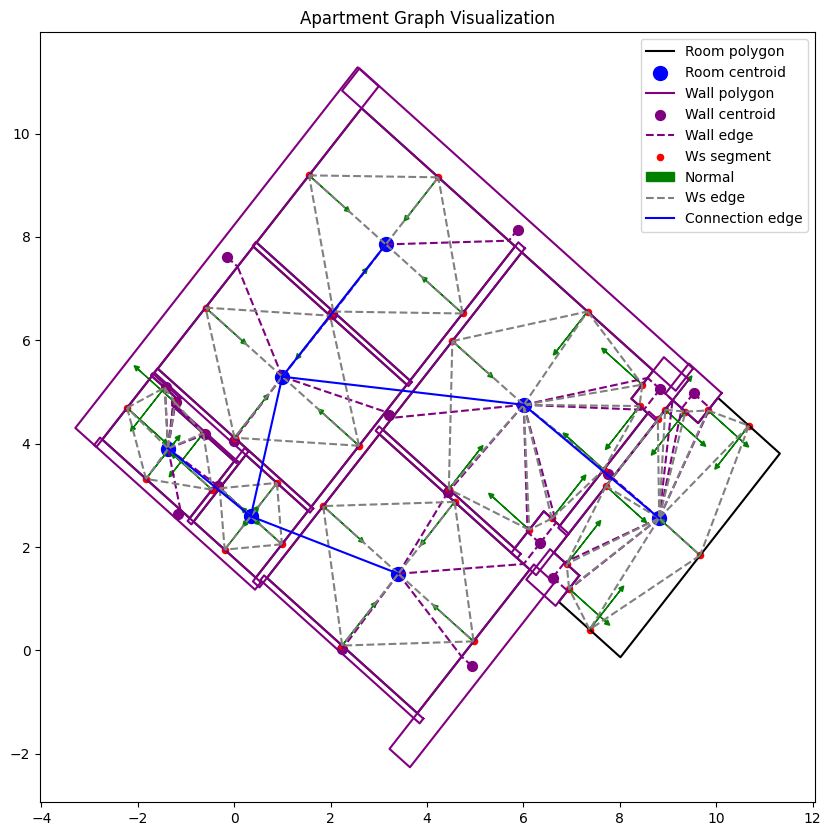

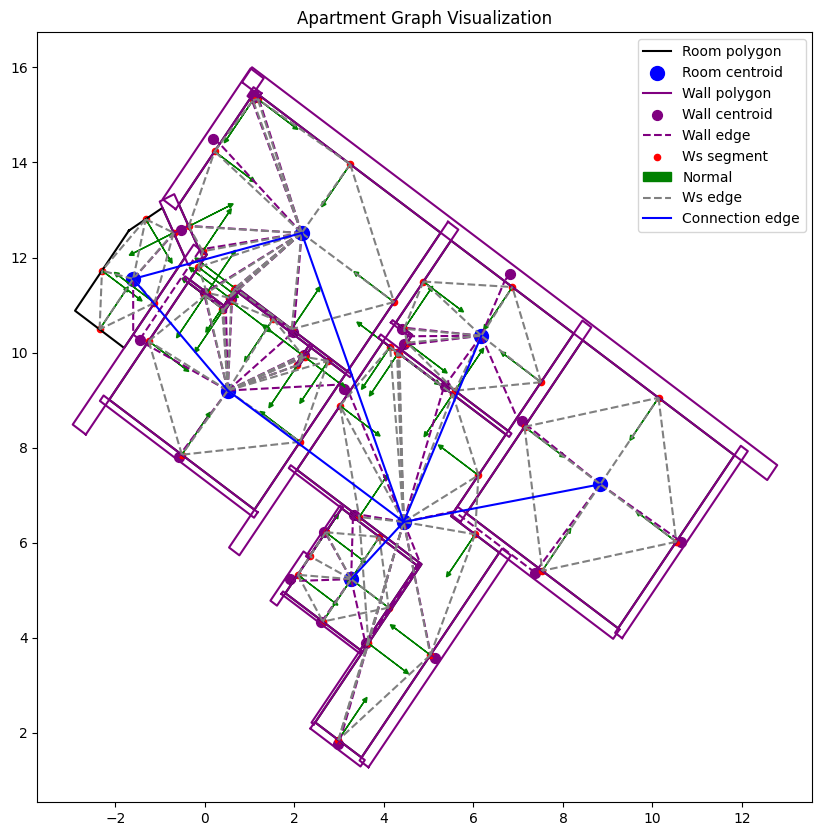

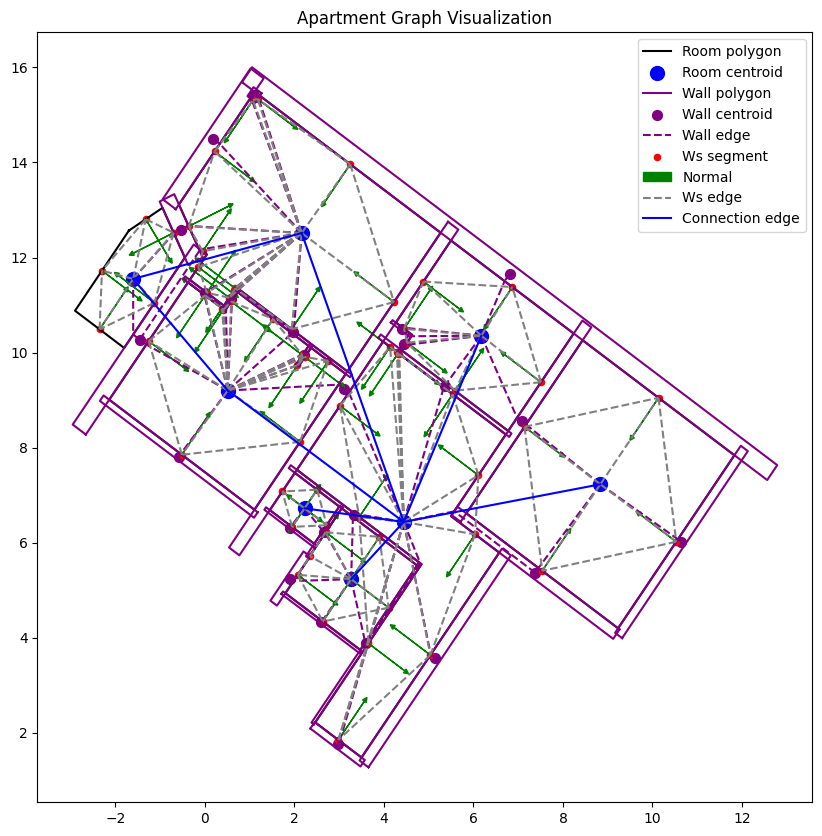

In [8]:
plot_a_graph([original_graphs[0]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

plot_a_graph([noise_graphs[60]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)
plot_a_graph([noise_graphs[61]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

53
176
270
77
144


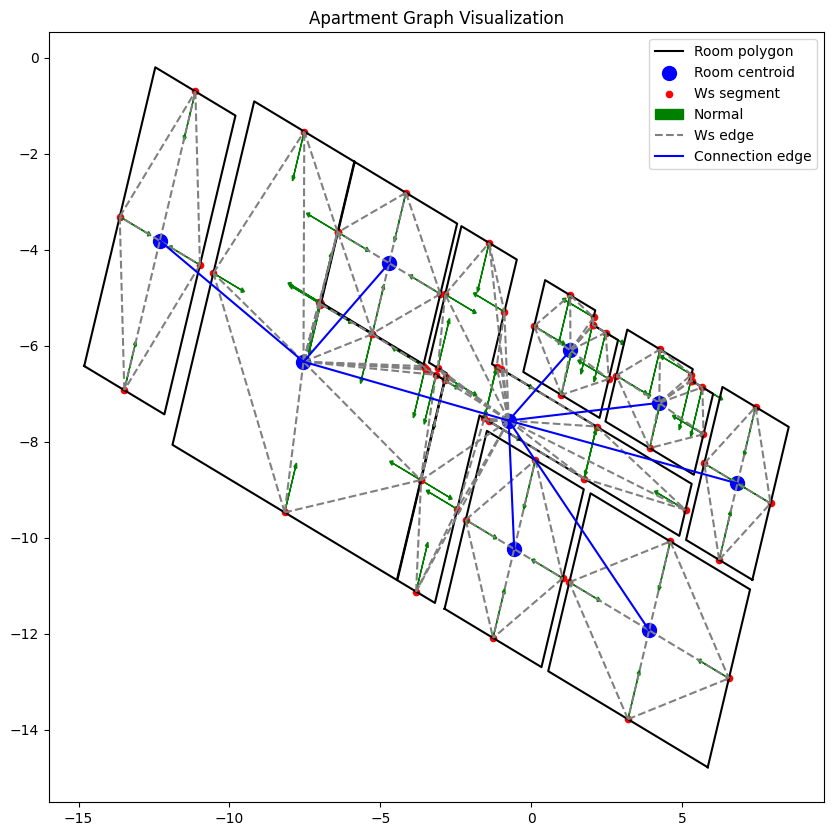

[(0, {'polygon': [(5.846049326444277, -14.779839661155272), (0.5601585648652261, -12.778463267850064), (1.9623488861879341, -9.075099477686202), (7.248239647766985, -11.076475870991409), (5.846049326444277, -14.779839661155272)], 'center': [3.9041991063161054, -11.927469569420737, 1.3], 'normal': [0, 0, 1], 'type': 'room', 'category': 0, 'category_letter': 'Bedroom'}), (1, {'geom': [array([  5.84604933, -14.77983966]), array([  0.56015856, -12.77846327])], 'polygon': [(5.846049326444277, -14.779839661155272), (0.5601585648652261, -12.778463267850064), (0.5601585648652261, -12.768463267850064), (5.846049326444277, -14.769839661155272), (5.846049326444277, -14.779839661155272)], 'center': [3.2031039456547514, -13.779151464502668, 1.3], 'normal': [0.3540947755505674, 0.9352095433258759, 0.0], 'width': 5.652092409986421, 'type': 'ws', 'category': 9}), (2, {'geom': [array([  0.56015856, -12.77846327]), array([ 1.96234889, -9.07509948])], 'polygon': [(0.5601585648652261, -12.778463267850064)

In [9]:
print(original_graphs[53].graph['name'])
print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
# remove all node which has type != "room" or "ws"
def remove_non_room_ws(graphs):
    for graph in graphs:
        nodes_to_remove = [n for n, d in graph.nodes(data=True) if d['type'] not in ['room', 'ws']]
        graph.remove_nodes_from(nodes_to_remove)
    return graphs
original_graphs = remove_non_room_ws(original_graphs)
noise_graphs = remove_non_room_ws(noise_graphs)

# convert id to int
for i, graph in enumerate(original_graphs):
    original_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')
for i, graph in enumerate(noise_graphs):
    noise_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')


print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
plot_a_graph([original_graphs[53]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=False)
print(original_graphs[53].nodes(data=True))
print(original_graphs[53].edges(data=True))

#### Generate G1,G2,GT dataset

Data(x=[77, 9], edge_index=[2, 144], node_names=[77], name='53')
G1 nodes: tensor([  1.0000,   0.0000,   3.9042, -11.9275,   1.3000,   0.0000,   0.0000,
          1.0000,  -1.0000])
Data(x=[77, 9], edge_index=[2, 144], node_names=[77], name='53')
G2 permuted nodes: tensor([ 0.0000,  1.0000, -3.5812, -6.4253,  1.3000, -0.9352,  0.3541,  0.0000,
         0.0485])
Ground truth permutation:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])


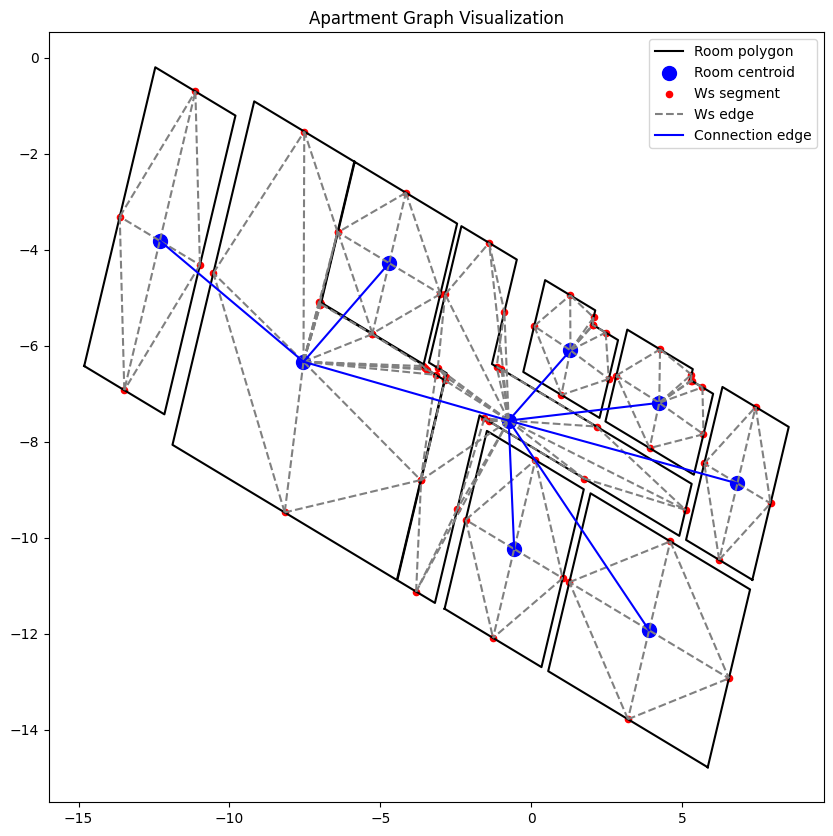

In [10]:
# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

train, val, test = split_graphs(original_graphs)

train_list = []
for i, g1 in enumerate(train):
    generate_matching_pairs_as_data(g1, train, i, train_list)

val_list = []
for i, g1 in enumerate(val):
    generate_matching_pairs_as_data(g1, val, i, val_list)

test_list = []
for i, g1 in enumerate(test):
    generate_matching_pairs_as_data(g1, test, i, test_list)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train_list[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs)

plot_a_graph(
    graphs_list=[g1_out],
    viz_rooms=True,
    viz_ws=True,
    viz_openings=False,
    viz_room_connection=True,
    viz_normals=False,
    viz_room_normals=False,
    viz_walls=False
)



In [11]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    return batch1, batch2, perm_list

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

### Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MatchingModel_2GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),
            GCNConv(hidden_dim, out_dim)
        ])

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x  # shape [num_nodes, out_dim]

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Args:
            x1, x2: node features of graph 1 and 2 (shapes [N, in_dim])
            edge_index1, edge_index2: edge indices of graph 1 and 2 ([2, num_edges])

        Returns:
            scores: similarity matrix [N, N], where scores[i, j] = node i in G1 vs node j in G2
        """
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]
        scores = torch.matmul(h1, h2.T)    # [N, N]
        return scores

### Training

In [13]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch and return the average loss and the embeddings.

    Returns:
        avg_loss, h1_all (list of h1), h2_all (list of h2)
    """
    model.train()
    total_loss = 0
    h1_all, h2_all = [], []

    for batch1, batch2, P in loader:
        optimizer.zero_grad()

        x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
        x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

        h1 = model.encode(x1, edge1)
        h2 = model.encode(x2, edge2)

        loss = 0.0
        B = len(P)

        for i in range(B):
            h1_i = h1[batch_idx1 == i]
            h2_i = h2[batch_idx2 == i]

            sim = torch.matmul(h1_i, h2_i.T)
            loss += F.binary_cross_entropy_with_logits(sim, P[i])

            h1_all.append(h1_i)
            h2_all.append(h2_i)

        loss /= B
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss, h1_all, h2_all


def evaluate(model, loader):
    """
    Evaluate the model on a validation/test set and return both accuracy and loss.

    Returns:
        accuracy, avg_loss
    """
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for batch1, batch2, P in loader:
            x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
            x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

            h1 = model.encode(x1, edge1)
            h2 = model.encode(x2, edge2)

            B = len(P)

            for i in range(B):
                h1_i = h1[batch_idx1 == i]
                h2_i = h2[batch_idx2 == i]

                sim = torch.matmul(h1_i, h2_i.T)

                pred = sim.argmax(dim=1)
                target = P[i].argmax(dim=1)

                correct += (pred == target).sum().item()
                total += h1_i.size(0)

                total_loss += F.binary_cross_entropy_with_logits(sim, P[i], reduction='sum').item()

    avg_loss = total_loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    return accuracy, avg_loss


In [14]:
from torch.utils.data import DataLoader

# Paths for saving models
best_val_model_path = os.path.join(GNN_PATH, 'best_val_model.pt')
final_model_path = os.path.join(GNN_PATH, 'final_model.pt')

# Define hyperparameters
in_dim = 9  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 100
learning_rate = 0.001
batch_size = 2

# Early stopping parameters
best_val_loss = float('inf')
patience = 20
patience_counter = 0
best_epoch = -1  # To track when best model was found


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

model = MatchingModel_2GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, _, _ = train_epoch(model, train_loader, optimizer)
    # Evaluate on validation set
    _, val_loss = evaluate(model, val_loader)
    # Accumulate Losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check if validation improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_epoch = epoch
        # Save the best model seen so far
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Print progress every 100 epochs
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the final model
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")

Starting training...
Epoch 0 | Train Loss: 33.8160 | Val Loss: 1966.7864
Epoch 99 | Train Loss: 0.7031 | Val Loss: 54.0304

Training completed.


### Training and Evalutation results

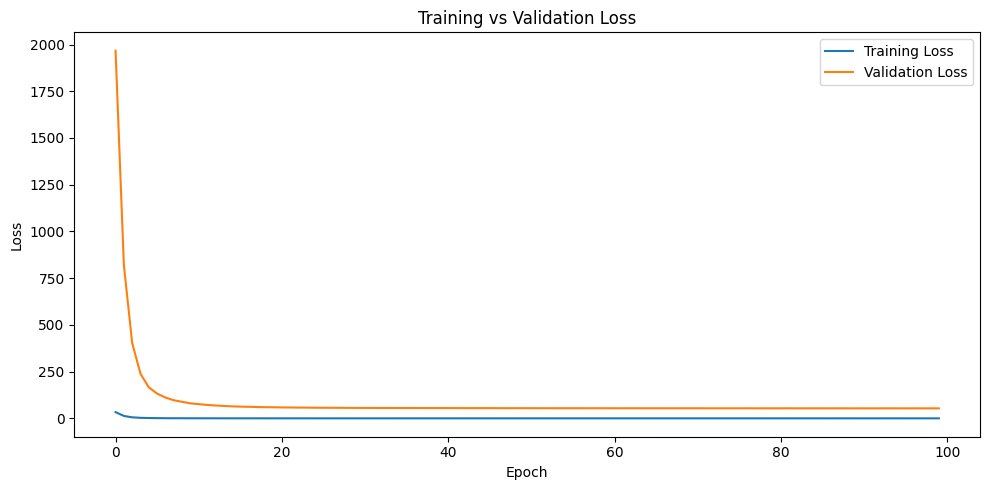

In [15]:
plot_losses(train_losses, val_losses)

In [16]:
# Load the best model
model.load_state_dict(torch.load(best_val_model_path))
model.eval()
# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 0.2439 | Test Loss: 58.4895


### Inference

In [17]:
import time

def predict_matching_matrix(model, data1, data2, hard=True):
    model.eval()
    with torch.no_grad():
        h1 = model.encode(data1.x, data1.edge_index)
        h2 = model.encode(data2.x, data2.edge_index)
        sim = torch.matmul(h1, h2.T)  # [N1, N2]

        if hard:
            pred = sim.argmax(dim=1)
            P_pred = torch.zeros_like(sim)
            P_pred[torch.arange(sim.size(0)), pred] = 1
            return P_pred
        else:
            return F.softmax(sim, dim=1)

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]
start_time = time.time()
P_pred = predict_matching_matrix(model, g1_out, g2_perm, hard=True)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")
print(P_pred)  # matrice binaria di permutazione predetta


Inference time: 0.015740 seconds
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Visualization of results

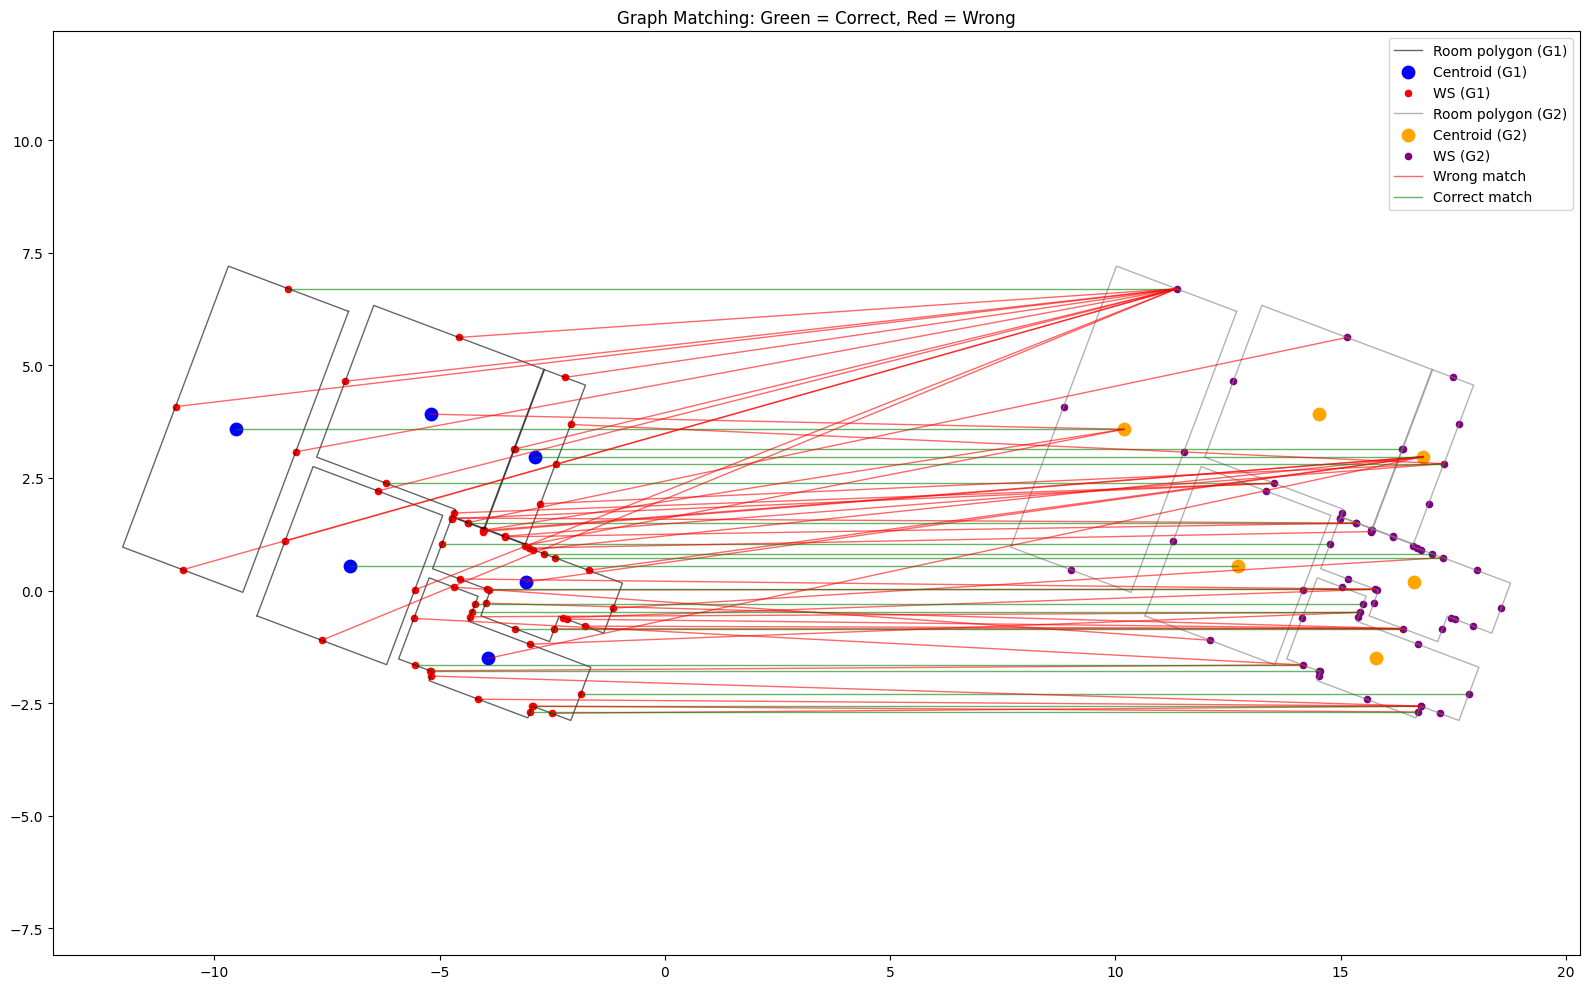

In [21]:
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=P_pred,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
)

# Graph matching

## Dataset Preprocessing


In [23]:
# Construct the folders if they don't exist 
# GNN_PATH
# ├── models
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global + local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room + ws dropout
# │       ├── room dropout
# │       └── ws dropout
# ├── preprocessed
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global + local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room + ws dropout
# │       ├── room dropout
# │       └── ws dropout
# └── raw
#     ├── graph matching
#     │   ├── equal
#     │   ├── global
#     │   ├── global + local
#     │   └── local
#     └── partial graph matching
#         ├── room + ws dropout
#         ├── room dropout
#         └── ws dropout
import os

def create_dir_structure(base_dir="GNN"):
    categories = [
        "graph matching/equal",
        "graph matching/global",
        "graph matching/global + local",
        "graph matching/local",
        "partial graph matching/room + ws dropout",
        "partial graph matching/room dropout",
        "partial graph matching/ws dropout",
    ]

    levels = ["models", "preprocessed", "raw"]

    for level in levels:
        for category in categories:
            path = os.path.join(base_dir, level, category)
            os.makedirs(path, exist_ok=True)

if __name__ == "__main__":
    create_dir_structure(GNN_PATH)


## Equal graphs

In [22]:
# TODO normalizza i dati in input 

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import pygmtools

pygmtools.BACKEND = 'pytorch'

class MatchingModel_GATv2Sinkhorn(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GATv2Conv(in_dim, hidden_dim),
            GATv2Conv(hidden_dim, out_dim)
        ])
        self.inst_norm = nn.InstanceNorm2d(1, affine=True)

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x

    def forward(self, batch1, batch2, batch_idx1, batch_idx2):
        x1, edge1 = batch1.x, batch1.edge_index
        x2, edge2 = batch2.x, batch2.edge_index

        h1 = self.encode(x1, edge1)
        h2 = self.encode(x2, edge2)

        B = batch1.num_graphs
        perm_pred_list = []
        all_embeddings = []

        for i in range(B):
            h1_i = h1[batch_idx1 == i]  # [N1, d]
            h2_i = h2[batch_idx2 == i]  # [N2, d]

            sim = torch.matmul(h1_i, h2_i.T)  # [N1, N2]
            sim_batched = sim.unsqueeze(0).unsqueeze(1)  # [1, 1, N1, N2]
            sim_normed = self.inst_norm(sim_batched).squeeze(1)  # [1, N1, N2]

            n1 = torch.tensor([h1_i.size(0)], dtype=torch.int32)
            n2 = torch.tensor([h2_i.size(0)], dtype=torch.int32)

            S = pygmtools.sinkhorn(sim_normed, n1=n1, n2=n2, dummy_row=False)[0]  # [N1, N2]

            perm_pred_list.append(S)
            all_embeddings.append((h1_i, h2_i))

        return perm_pred_list, all_embeddings


/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
def train_epoch_sinkhorn(model, loader, optimizer):
    model.train()
    total_loss = 0
    all_embeddings = []

    for batch1, batch2, perm_list in loader:
        optimizer.zero_grad()
        batch_idx1 = batch1.batch
        batch_idx2 = batch2.batch

        pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

        loss = sum(F.binary_cross_entropy(pred, target) for pred, target in zip(pred_perm_list, perm_list))
        loss /= len(perm_list)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_embeddings.extend(batch_embeddings)

    avg_loss = total_loss / len(loader)
    return avg_loss, all_embeddings

def evaluate_sinkhorn(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    all_embeddings = []

    with torch.no_grad():
        for batch1, batch2, perm_list in loader:
            batch_idx1 = batch1.batch
            batch_idx2 = batch2.batch

            pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

            for pred, target in zip(pred_perm_list, perm_list):
                pred_indices = pred.argmax(dim=1)
                target_indices = target.argmax(dim=1)
                correct += (pred_indices == target_indices).sum().item()
                total += pred.size(0)

            loss = sum(F.binary_cross_entropy(pred, target) for pred, target in zip(pred_perm_list, perm_list))
            total_loss += loss.item()
            all_embeddings.extend(batch_embeddings)

    avg_acc = correct / total if total > 0 else 0
    avg_loss = total_loss / len(loader)
    return avg_acc, avg_loss, all_embeddings


In [25]:
from torch.utils.data import DataLoader
import os

# Percorsi per salvare i modelli
GNN_PATH = "models"  # puoi cambiare questo path
os.makedirs(GNN_PATH, exist_ok=True)
best_val_model_path = os.path.join(GNN_PATH, 'best_val_model.pt')
final_model_path = os.path.join(GNN_PATH, 'final_model.pt')

# Iperparametri
in_dim = 9
hidden_dim = 64
out_dim = 32
num_epochs = 100
learning_rate = 0.001
batch_size = 3

# Early stopping
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_epoch = -1

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Tracciamento delle loss
train_losses = []
val_losses = []

print("Starting training with Sinkhorn...")

for epoch in range(num_epochs):
    # Train
    train_loss, train_embeddings = train_epoch_sinkhorn(model, train_loader, optimizer)
    # Validate
    val_acc, val_loss, val_embeddings = evaluate_sinkhorn(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Salva il miglior modello
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Logging
    print(f"Epoch {epoch:03} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best was {best_epoch}.")
        break

# Salva anche il modello finale
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")


Starting training with Sinkhorn...
Epoch 000 | Train Loss: 0.0651 | Val Loss: 0.1800 | Val Acc: 0.2243
Epoch 001 | Train Loss: 0.0646 | Val Loss: 0.1736 | Val Acc: 0.2473
Epoch 002 | Train Loss: 0.0609 | Val Loss: 0.1677 | Val Acc: 0.3074
Epoch 003 | Train Loss: 0.0592 | Val Loss: 0.1644 | Val Acc: 0.3446
Epoch 004 | Train Loss: 0.0575 | Val Loss: 0.1610 | Val Acc: 0.4037
Epoch 005 | Train Loss: 0.0577 | Val Loss: 0.1577 | Val Acc: 0.4661
Epoch 006 | Train Loss: 0.0554 | Val Loss: 0.1535 | Val Acc: 0.5109
Epoch 007 | Train Loss: 0.0540 | Val Loss: 0.1485 | Val Acc: 0.5536
Epoch 008 | Train Loss: 0.0530 | Val Loss: 0.1439 | Val Acc: 0.6072
Epoch 009 | Train Loss: 0.0502 | Val Loss: 0.1393 | Val Acc: 0.6455
Epoch 010 | Train Loss: 0.0500 | Val Loss: 0.1365 | Val Acc: 0.6772
Epoch 011 | Train Loss: 0.0484 | Val Loss: 0.1324 | Val Acc: 0.7112
Epoch 012 | Train Loss: 0.0467 | Val Loss: 0.1294 | Val Acc: 0.7484
Epoch 013 | Train Loss: 0.0461 | Val Loss: 0.1274 | Val Acc: 0.7790
Epoch 014 | T

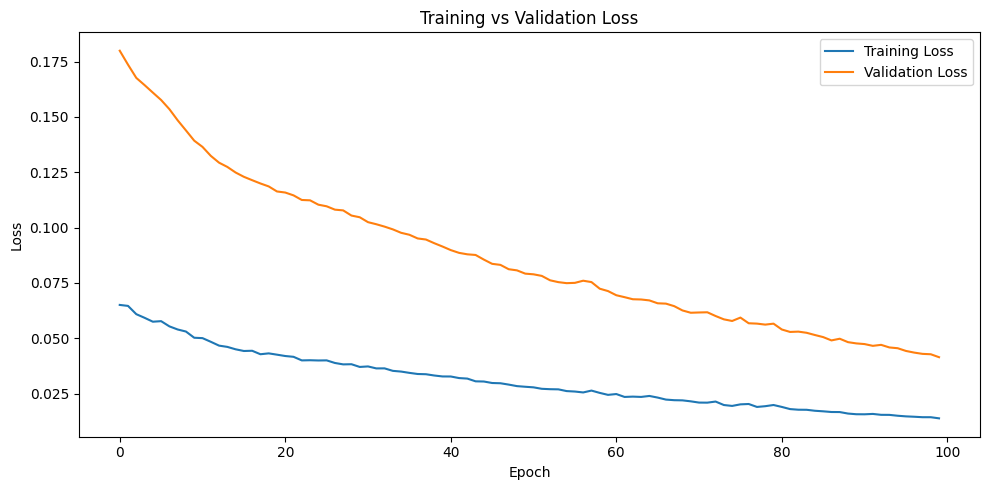

In [26]:
plot_losses(train_losses, val_losses)

In [27]:
def predict_matching_matrix(model, data1, data2):
    model.eval()
    with torch.no_grad():
        h1 = model.encode(data1.x, data1.edge_index).unsqueeze(0)  # [1, N1, D]
        h2 = model.encode(data2.x, data2.edge_index).unsqueeze(0)  # [1, N2, D]

        M = torch.matmul(h1, h2.transpose(1, 2))  # [1, N1, N2]
        M = model.inst_norm(M.unsqueeze(1)).squeeze(1)  # [1, N1, N2]

        n1 = torch.tensor([h1.shape[1]], dtype=torch.int32)  # as Tensor
        n2 = torch.tensor([h2.shape[1]], dtype=torch.int32)

        pred = pygmtools.hungarian(M, n1=n1, n2=n2).squeeze(0)  # [N1, N2]
        return pred

# Carica il miglior modello
model.load_state_dict(torch.load(best_val_model_path))

test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]
start_time = time.time()
result = predict_matching_matrix(model, g1_out, g2_perm)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

print(result)  # matrice binaria di permutazione predetta


Test Accuracy: 0.9944 | Test Loss: 0.0459
Inference time: 0.004373 seconds
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Number of errors: 0


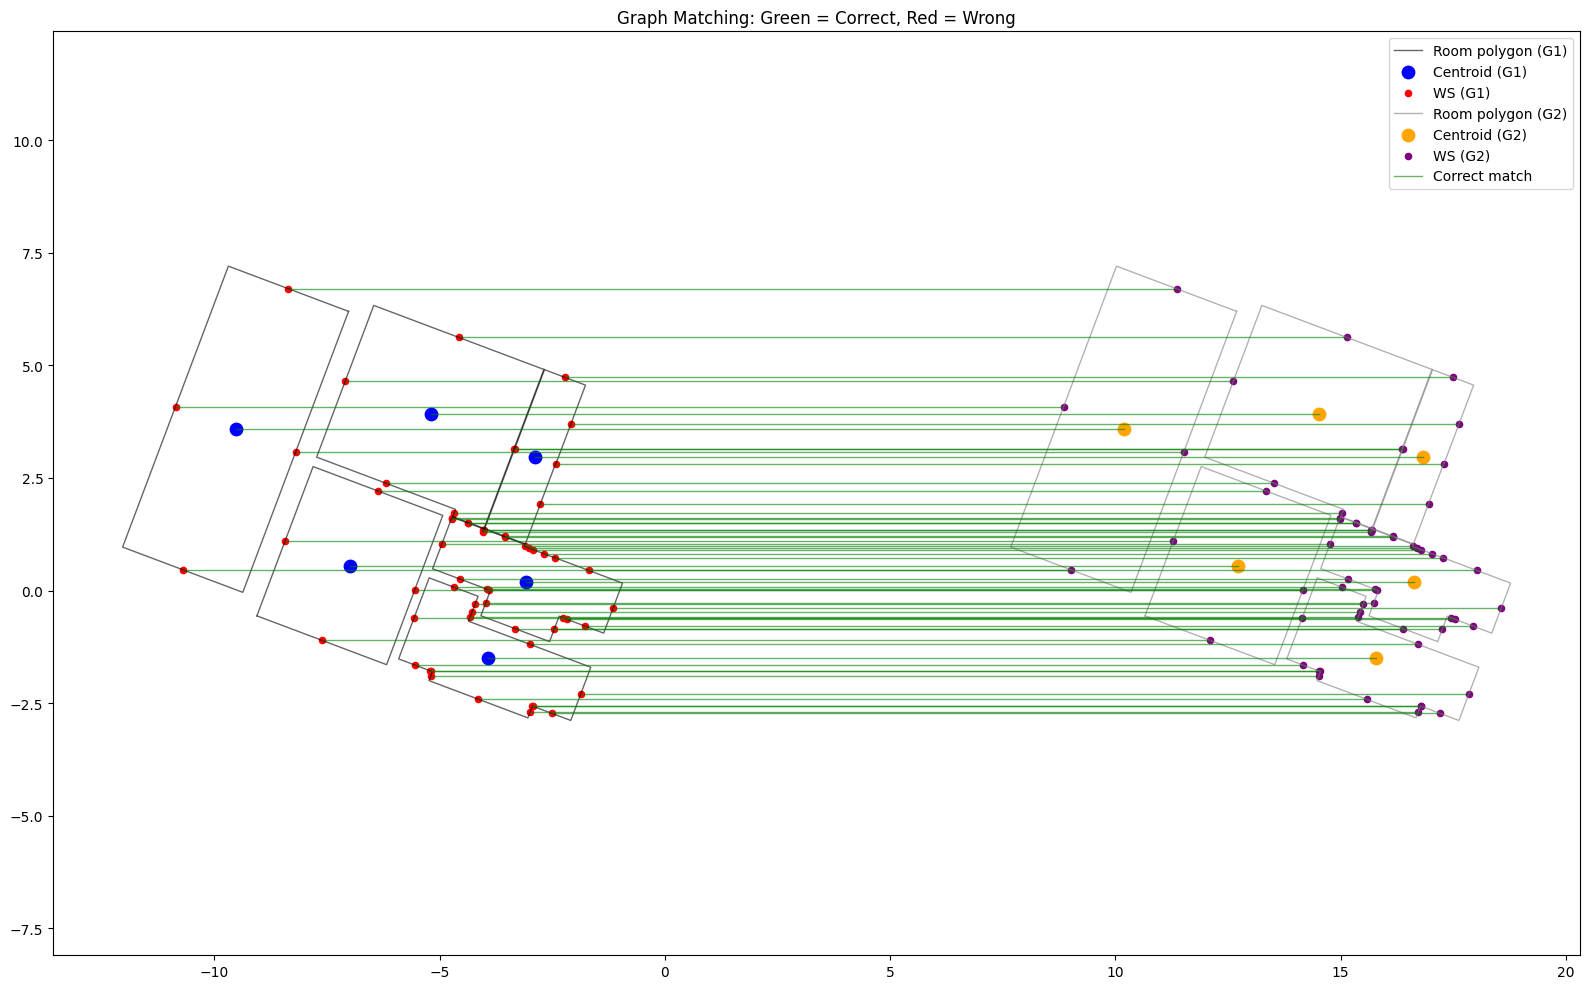

In [28]:
# g1 = pyg_data_to_nx_digraph(g1_out, original_graphs)
# g2 = pyg_data_to_nx_digraph(g2_perm, original_graphs)

# # Applica la permutazione inversa
# inv_perm = gt_perm.T.argmax(dim=1)
# g2_reordered = apply_inverse_permutation_to_graph(g2, inv_perm)

# # Check if the permuted graphs are equal
# # conver g2_reordered in pyg
# g2_reordered_pyg = nx_to_pyg_data_preserve_order(g2_reordered)
# assert torch.equal(g2_perm.x, g2_reordered_pyg.x), "I tensori non sono uguali!"


errors = (result != gt_perm).sum().item()
print(f"Number of errors: {errors}")

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="correct",
)

## Local noise 

## Local noise 

## Global + Local noise 

# Partial graph matching

## Ws dropout

## Room Dropout

## Ws + Room Dropout